# Classify snow-covered area (SCA) in Landsat surface reflectance imagery: full pipeline

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Load images__ over the AOI 

__2. Classify SCA__ and use the snow elevations distribution to estimate the seasonal snowline

__3. Delineate snowlines__ using classified images. 

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'SouthCascade'
# path to snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to AOI including the name of the shapefile
AOI_fn = base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
# path to DEM including the name of the tif file
# Note: set DEM_fn=None if you want to use the ASTER GDEM on Google Earth Engine
DEM_fn = base_path + '../study-sites/' + site_name + '/DEMs/' + site_name + '*_DEM*.tif'
# path for output images
out_path = base_path + '../study-sites/' + site_name + '/imagery/Landsat/'
# path for output figures
figures_out_path = base_path + '../study-sites/' + site_name + '/figures/'

# -----Define image search filters
date_start = '2022-01-01'
date_end = '2022-12-01'
month_start = 5
month_end = 10
cloud_cover_max = 100

# -----Determine settings
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max blue SR < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCA images to file
save_figures = True # = True to save SCA output figures to file

#######################

# -----Import packages
import xarray as xr
import rioxarray
import wxee as wx
import os
import numpy as np
import glob
from osgeo import gdal
import matplotlib
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt, dates
import rasterio as rio
import rasterio.features
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Polygon, shape
import shapely.geometry
from scipy.interpolate import interp2d
from scipy import stats
import pandas as pd
import geopandas as gpd
import geemap
import math
import sys
import ee
import fiona
import pickle
import wxee as wx
import time

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils_PlanetScope as pf
import pipeline_utils_Landsat as lf

# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)
dataset = 'Landsat'
ds_dict = dataset_dict[dataset]

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

#### Load AOI and DEM

In [3]:
# -----Load AOI as gpd.GeoDataFrame
AOI_fn = glob.glob(AOI_fn)[0]
AOI = gpd.read_file(AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs(4326)
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
epsg_UTM = lf.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
    
# -----Load DEM as Xarray DataSet
if DEM_fn==None:
    
    # query GEE for DEM
    DEM, AOI_UTM = lf.query_GEE_for_DEM(AOI)
    
else:
    
    # reproject AOI to UTM
    AOI_UTM = AOI.to_crs(str(epsg_UTM))
    # load DEM as xarray DataSet
    DEM_fn = glob.glob(DEM_fn)[0]
    DEM_rio = rio.open(DEM_fn) # open using rasterio to access the transform
    DEM = xr.open_dataset(DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject(str('EPSG:'+epsg_UTM))

## 1. Load images over the AOI and mask cloudy pixels using the `QA_PIXEL` band


In [4]:
# -----Check if masked surface reflectance images already exist in file
im_masked_fn = 'Landsat_SR_' + date_start.replace('-','') + '_' + date_end.replace('-','') + '_masked.nc'
if len(glob.glob(out_path + im_masked_fn)) > 0:
    
    # load masked imagery from file
    print('Landsat masked SR image collection already exists in file, loading...')
    L_mask = xr.open_dataset(out_path + im_masked_fn)
                             
else:

    # query GEE for SR images
    print('Querying GEE for SR image...')
    L = lf.query_GEE_for_Landsat_SR(AOI, date_start, date_end, month_start, month_end, cloud_cover_max, ds_dict)

    # mask cloudy pixels using the QA_PIXEL band
    L_mask = lf.Landsat_mask_clouds(L, AOI, plot_results)
    
    # save outputs
    L_mask.to_netcdf(out_path + im_masked_fn)
    print('Landsat masked SR image collection saved to file: ' + out_path + im_masked_fn)

Landsat masked SR image collection already exists in file, loading...


## 2. Classify images

2022-06-10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-06-10_SCA.png
2022-06-26
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-06-26_SCA.png
2022-08-22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-08-22_SCA.png
2022-09-30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-09-30_SCA.png
2022-10-16
figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-10-16_SCA.png
Landsat classified image collection saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/Landsat/Landsat_SR_20220101_20221201_masked_classified.nc


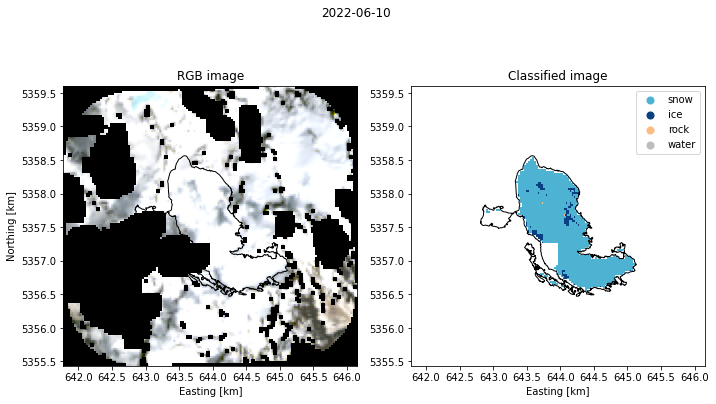

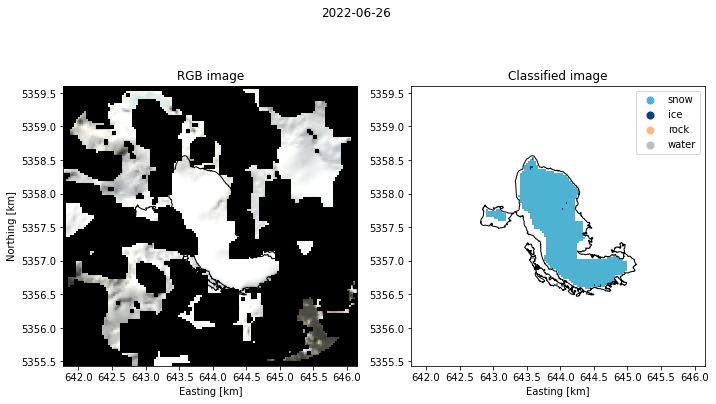

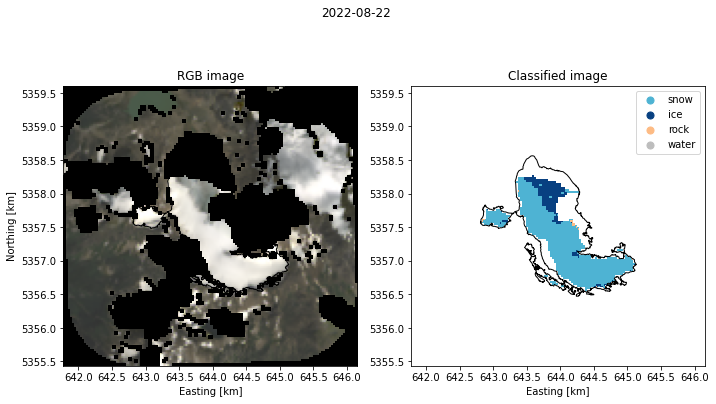

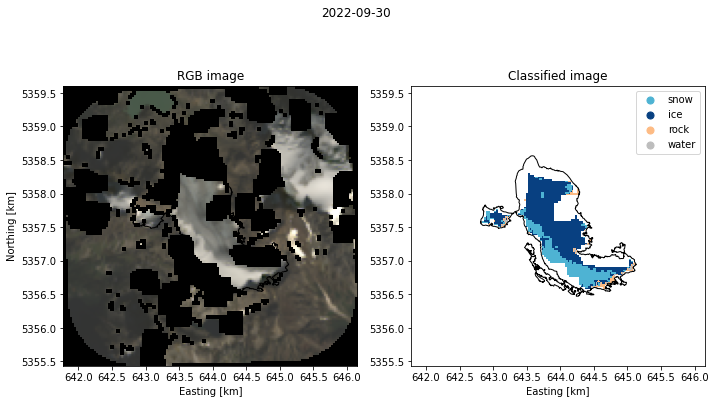

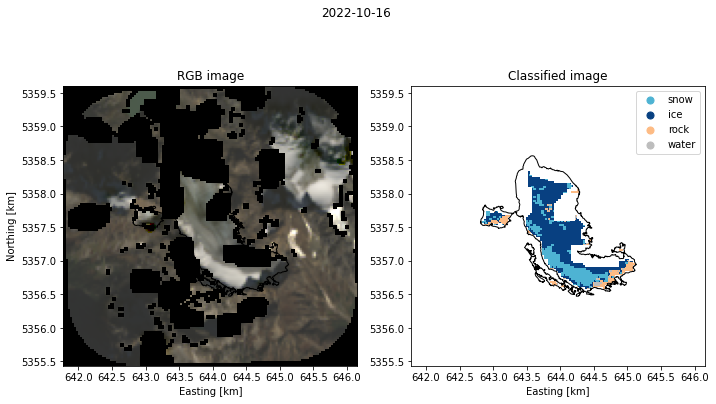

In [5]:
# load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/L_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/L_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# classify images
L_mask_classified, L_mask_classified_fn, fig = lf.classify_image_collection(L_mask, clf, feature_cols, crop_to_AOI, AOI, ds_dict, out_path, date_start, date_end, plot_results, figures_out_path)


#### Optional: Compile individual figures into a .gif and delete individual figures

In [ ]:
 from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image

# -----Make a .gif of output images
os.chdir(figures_out_path)
fig_fns = glob.glob('L_*SCA.png') # load all output figure file names
fig_fns = sorted(fig_fns) # sort chronologically

# grab figures date range for .gif file name
frames = [PIL_Image.open(im) for im in fig_fns]
frame_one = frames[0]
gif_fn = ('Landsat_' + date_start.replace('-','') + '_' + date_end.replace('-','') + '_SCA.gif' )
frame_one.save(figures_out_path + gif_fn, format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
print('GIF saved to file:' + figures_out_path + gif_fn)

# -----Display .gif
IPy_Image(filename = figures_out_path + gif_fn)

# -----Clean up: delete individual figure files
for fn in fig_fns:
    os.remove(os.path.join(figures_out_path, fn))
print('Individual figure files deleted.')

## 3. Delineate snowlines

In [6]:
snowlines_df = lf.Landsat_delineate_snow_line(L_mask, L_mask_classified, 
                                              date_start, date_end, site_name, AOI_UTM, DEM, 
                                              out_path, figures_out_path, plot_results)


2022-06-10


AttributeError: 'Dataset' object has no attribute 'classification'

2022-06-10


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


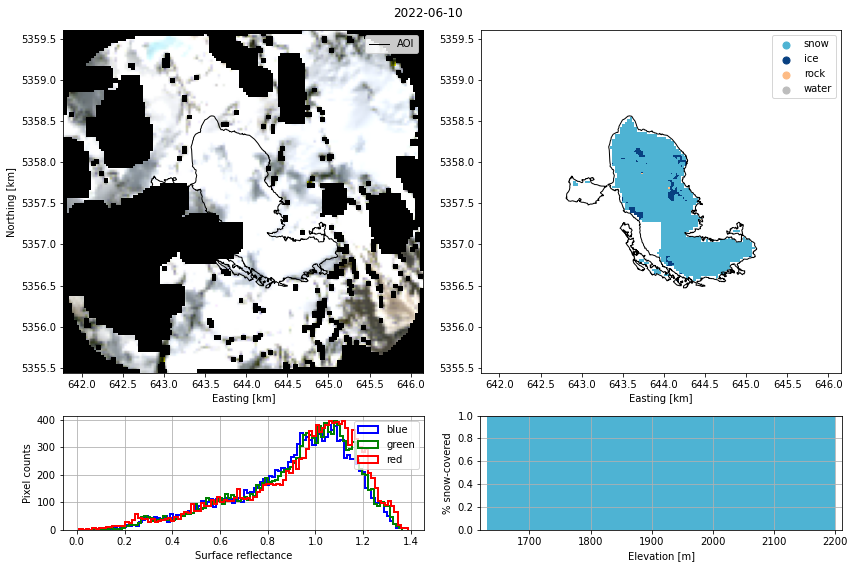

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-06-10_snowline.png
2022-06-26


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


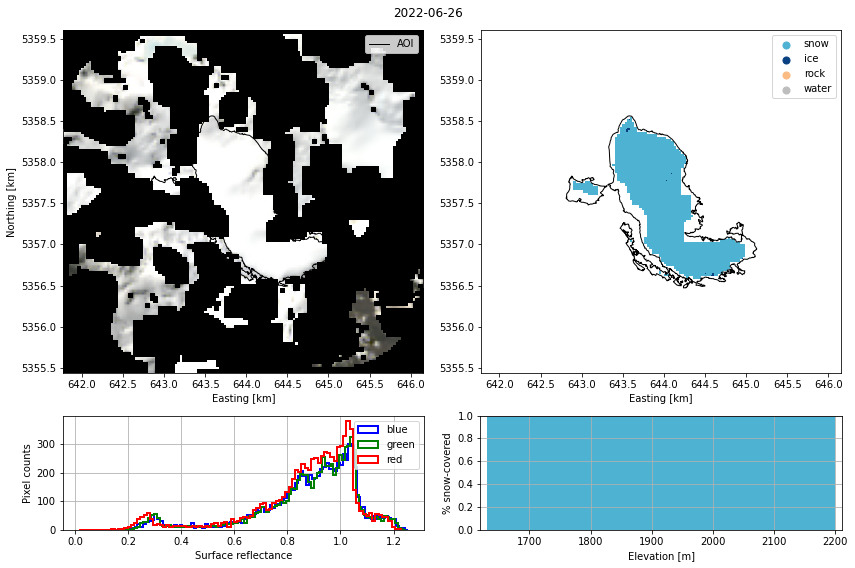

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-06-26_snowline.png
2022-08-22


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


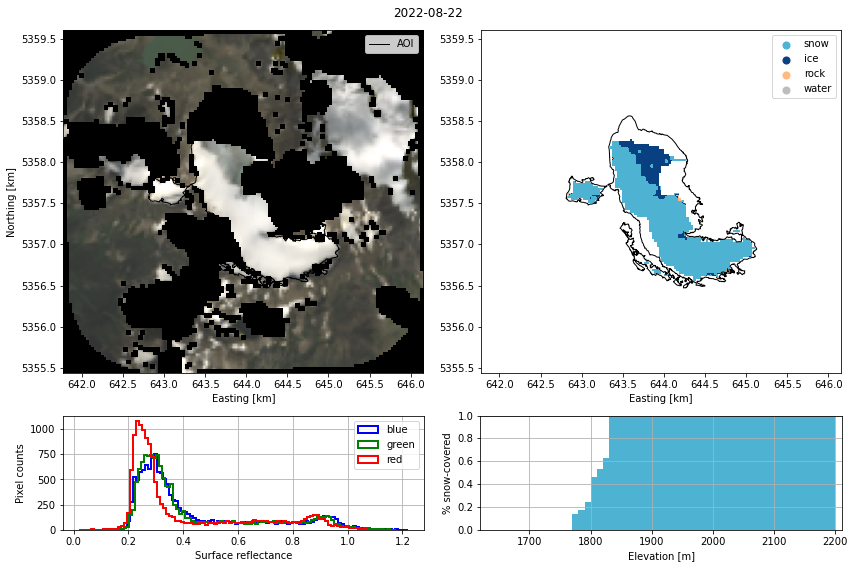

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-08-22_snowline.png
2022-09-30


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


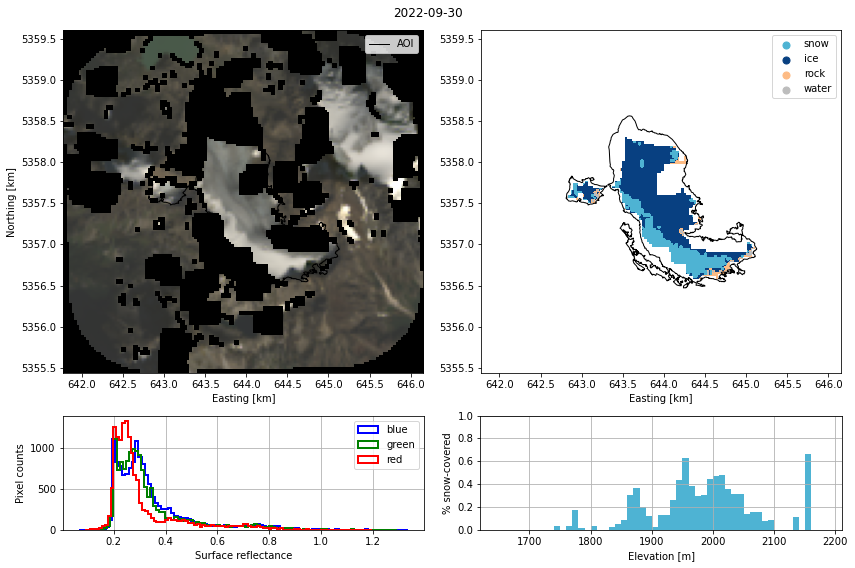

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-09-30_snowline.png
2022-10-16


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


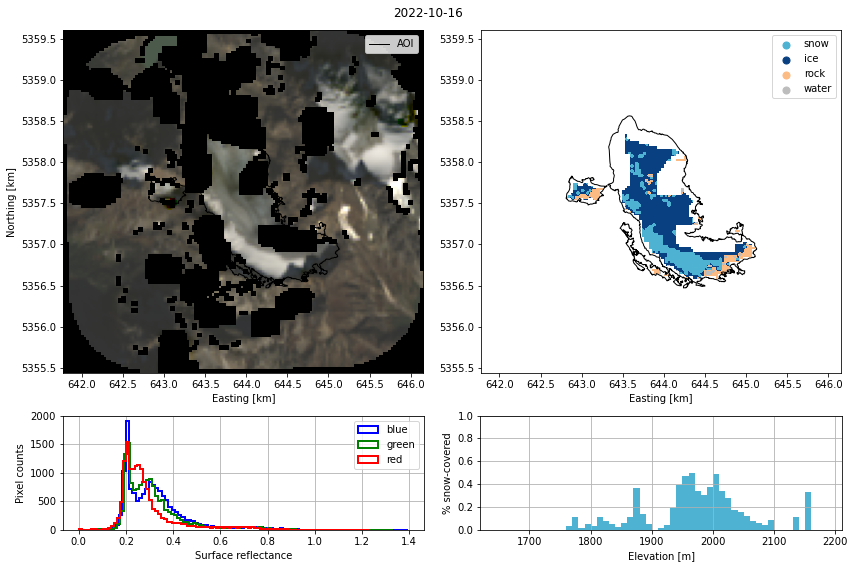

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-10-16_snowline.png
 
snowline data table saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/Landsat/Landsat_20220101_20221201_snowlines.pkl


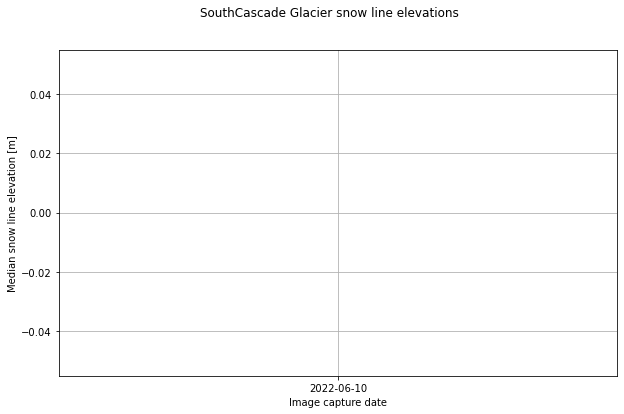

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures/Landsat_2022-10-16_snowline.png


In [55]:
im_collection = L_mask
im_collection_classified = L_mask_classified
from shapely.geometry import LineString

# -----Check if classified snow image collection exists in directory already
snowlines_fn = 'Landsat_SR_' + date_start.replace('-','') + '_' + date_end.replace('-','') + '_snowlines.pkl'
if os.path.exists(os.path.join(out_path, snowlines_fn)):

    print('snowlines already exist in file, loading...')
    snowlines = pickle.load(open(out_path + snowlines_fn,'r'))
    fig = 'N/A'

else:

    # -----Initialize results data frame
    results_df = pd.DataFrame(columns=['study_site', 'datetime', 'snowlines_coords', 'snowlines_elevs', 'snowlines_elevs_median'])

    # -----Define image bands
    bands = [x for x in im_collection.data_vars]
    bands = [band for band in bands if band != 'QA_PIXEL']

    # -----Loop through image capture dates
    for i, t in enumerate(im_collection.time):

        im_date = str(t.data)[0:10]
        print(im_date)

        # -----Subset image collections
        im = im_collection.sel(time=t)
        im_classified = im_collection_classified.sel(time=t)

        # -----Create no data mask
        no_data_mask = xr.where(~np.isnan(im_classified), 1, 0).to_array().data[0]
        # convert to polygons
        no_data_polygons = []
        for s, value in rio.features.shapes(no_data_mask.astype(np.int16),
                                            mask=(no_data_mask > 0),
                                            transform=im.rio.transform()):
            no_data_polygons.append(shape(s))
        no_data_polygons = MultiPolygon(no_data_polygons)

        # -----Mask the DEM using the AOI
        # create AOI mask
        mask_AOI = rio.features.geometry_mask(AOI.geometry,
                                          out_shape=(len(DEM.y), len(DEM.x)),
                                          transform=DEM.rio.transform(),
                                          invert=True)
        # convert mask to xarray DataArray
        mask_AOI = xr.DataArray(mask_AOI , dims=("y", "x"))
        # mask DEM values outside the AOI
        DEM_AOI = DEM.copy(deep=True)
        DEM_AOI.elevation.data = np.where(mask_AOI==True, DEM_AOI.elevation.data, np.nan)

        # -----Interpolate DEM to the image coordinates
        DEM_AOI_interp = DEM_AOI.interp(x=im_classified.x.data,
                                        y=im_classified.y.data,
                                        method="nearest")

        # -----Determine snow covered elevations
        # create array of snow-covered pixel elevations
        snow_est_elev = np.ravel(np.where(im_classified.classified.data <= 2, DEM_AOI_interp.elevation.data, np.nan))
        # remove NaNs
        snow_est_elev = snow_est_elev[~np.isnan(snow_est_elev)]

        # -----Create elevation histograms
        # determine bins to use in histograms
        elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
        elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
        bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
        bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
        # calculate elevation histograms
        H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
        H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
        H_snow_est_elev_norm = H_snow_est_elev / H_DEM

        # -----Make all pixels at elevations >75% snow coverage snow
        # determine elevation with > 75% snow coverage
        if len(np.where(H_snow_est_elev_norm > 0.75)[0]) > 1:
            elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]
            # set all pixels above the elev_75_snow to snow (1)
            im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
            im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
            H_snow_est_elev_norm[bin_centers >= elev_75_snow] = 1
        else:
            im_classified_adj = im_classified.squeeze(drop=True)

        # -----Delineate snow lines
        # create binary snow matrix
        im_binary = xr.where(im_classified_adj  > 2, 1, 0)
        # apply median filter to binary image with kernel_size of 1 pixel (~30 m)
        im_binary_filt = medfilt(im_binary['classified'].data, kernel_size=1)
        # fill holes in binary image (0s within 1s = 1)
        im_binary_filt_no_holes = binary_fill_holes(im_binary_filt)
        # find contours at a constant value of 0.5 (between 0 and 1)
        contours = find_contours(im_binary_filt_no_holes, 0.5)
        # convert contour points to image coordinates
        contours_coords = []
        for contour in contours:
            ix = np.round(contour[:,1]).astype(int)
            iy = np.round(contour[:,0]).astype(int)
            coords = (im.isel(x=ix, y=iy).x.data, # image x coordinates
                      im.isel(x=ix, y=iy).y.data) # image y coordinates
            # zip points together
            xy = list(zip([x for x in coords[0]],
                          [y for y in coords[1]]))
            contours_coords = contours_coords + [xy]
        # create snow-free polygons
        c_polys = []
        for c in contours_coords:
            c_points = [Point(x,y) for x,y in c]
            c_poly = Polygon([[p.x, p.y] for p in c_points])
            c_polys = c_polys + [c_poly]
        # only save the largest polygon
        if len(c_polys) > 0:
            # calculate polygon areas
            areas = np.array([poly.area for poly in c_polys])
            # grab top 3 areas with their polygon indices
            areas_max = sorted(zip(areas, np.arange(0,len(c_polys))), reverse=True)[:1]
            # grab indices
            ic_polys = [x[1] for x in areas_max]
            # grab polygons at indices
            c_polys = [c_polys[i] for i in ic_polys]
                
        # extract coordinates in polygon
        polys_coords = [list(zip(c.exterior.coords.xy[0], c.exterior.coords.xy[1]))  for c in c_polys]
        # extract snow lines (sl) from contours
        # filter contours using no data and AOI masks (i.e., along glacier outline or data gaps)
        sl_est = [] # initialize list of snow lines
        min_sl_length = 100 # minimum snow line length
        for c in polys_coords:
            # create array of points
            c_points =  [Point(x,y) for x,y in c]
            # loop through points
            line_points = [] # initialize list of points to use in snow line
            for point in c_points:
                # calculate distance from the point to the no data polygons and the AOI boundary
                distance_no_data = no_data_polygons.distance(point)
                distance_AOI = AOI.boundary[0].distance(point)
                # only include points 100 m from both
                if (distance_no_data >= 30) and (distance_AOI >=30):
                    line_points = line_points + [point]
            if line_points: # if list of line points is not empty
                if len(line_points) > 1: # must have at least two points to create a LineString
                    line = LineString([(p.xy[0][0], p.xy[1][0]) for p in line_points])
                    if line.length > min_sl_length:
                        sl_est = sl_est + [line]

        # -----Split lines with points more than 100 m apart and filter by length
        # check if any snow lines were found
        if sl_est:
            sl_est = sl_est[0]
            max_dist = 100 # m
            first_point = Point(sl_est.coords.xy[0][0], sl_est.coords.xy[1][0])
            points = [Point(sl_est.coords.xy[0][i], sl_est.coords.xy[1][i])
                      for i in np.arange(0,len(sl_est.coords.xy[0]))]
            isplit = [0] # point indices where to split the line
            for i, p in enumerate(points):
                if i!=0:
                    dist = p.distance(points[i-1])
                    if dist > max_dist:
                        isplit.append(i)
            isplit.append(len(points)) # add ending point to complete the last line
            sl_est_split = [] # initialize split lines
            # loop through split indices
            if len(isplit) > 1:
                for i, p in enumerate(isplit[:-1]):
                    if isplit[i+1]-isplit[i] > 1: # must have at least two points to make a line
                        line = LineString(points[isplit[i]:isplit[i+1]])
                        if line.length > min_sl_length:
                            sl_est_split = sl_est_split + [line]
            else:
                sl_est_split = [sl_est]

            # -----Interpolate elevations at snow line coordinates
            # compile all line coordinates into arrays of x- and y-coordinates
            xpts, ypts = [], []
            for line in sl_est_split:
                xpts = xpts + [x for x in line.coords.xy[0]]
                ypts = ypts + [y for y in line.coords.xy[1]]
            xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
            # interpolate elevation at snow line points
            sl_est_elev = [DEM.sel(x=x, y=y, method='nearest').elevation.data[0]
                           for x, y in list(zip(xpts, ypts))]

        else:
            sl_est_split = None
            sl_est_elev = np.nan

        # -----Concatenate results to df
        # calculate median snow line elevation
        sl_est_elev_median = np.nanmedian(sl_est_elev)
        # compile results in df
        result_df = pd.DataFrame({'study_site': site_name,
                                  'datetime': im_date,
                                  'snowlines_coords': [sl_est],
                                  'snowlines_elevs': [sl_est_elev],
                                  'snowlines_elevs_median': sl_est_elev_median})
        # concatenate to results_df
        results_df = pd.concat([results_df, result_df])

        # -----Plot results
        if plot_results:
            contour = None
            fig, ax = plt.subplots(2, 2, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
            ax = ax.flatten()
            # define x and y limits
            xmin, xmax = np.min(im_classified.x.data)/1e3, np.max(im_classified.x.data)/1e3
            ymin, ymax = np.min(im_classified.y.data)/1e3, np.max(im_classified.y.data)/1e3
            # define colors for plotting
            color_snow = '#4eb3d3'
            color_ice = '#084081'
            color_rock = '#fdbb84'
            color_water = '#bdbdbd'
            color_contour = '#f768a1'
            # create colormap
            colors = [color_snow, color_snow, color_ice, color_rock, color_water]
            cmp = matplotlib.colors.ListedColormap(colors)
            # RGB image
            ax[0].imshow(np.dstack([im[ds_dict['RGB_bands'][0]].data, 
                                    im[ds_dict['RGB_bands'][1]].data, 
                                    im[ds_dict['RGB_bands'][2]].data]),
                         extent=(xmin, xmax, ymin, ymax))
            ax[0].set_xlabel("Easting [km]")
            ax[0].set_ylabel("Northing [km]")
            # classified image
            ax[1].imshow(im_classified['classified'].data, cmap=cmp, vmin=1, vmax=5,
                         extent=(xmin, xmax, ymin, ymax))
            # plot dummy points for legend
            ax[1].scatter(0, 0, color=color_snow, s=50, label='snow')
            ax[1].scatter(0, 0, color=color_ice, s=50, label='ice')
            ax[1].scatter(0, 0, color=color_rock, s=50, label='rock')
            ax[1].scatter(0, 0, color=color_water, s=50, label='water')
            ax[1].set_xlabel('Easting [km]')
            # AOI
            if AOI.geometry[0].geom_type=='MultiPolygon': # loop through geoms if AOI = MultiPolygon
                for j, poly in enumerate(AOI.geometry[0].geoms):
                    if j==0:
                        ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
                    else:
                        ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')                            
                    ax[1].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
            else:
                ax[0].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
                ax[1].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
            # reset x and y limits
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[1].set_xlim(xmin, xmax)
            ax[1].set_ylim(ymin, ymax)
            # image bands histogram
            h_b = ax[2].hist(im[ds_dict['RGB_bands'][0]].data.flatten(), color='blue', histtype='step', linewidth=2, bins=100, label="blue")
            h_g = ax[2].hist(im[ds_dict['RGB_bands'][1]].data.flatten(), color='green', histtype='step', linewidth=2, bins=100, label="green")
            h_r = ax[2].hist(im[ds_dict['RGB_bands'][2]].data.flatten(), color='red', histtype='step', linewidth=2, bins=100, label="red")
            ax[2].set_xlabel("Surface reflectance")
            ax[2].set_ylabel("Pixel counts")
            ax[2].legend(loc='best')
            ax[2].grid()
            # normalized snow elevations histogram
            ax[3].bar(bin_centers, H_snow_est_elev_norm, width=(bin_centers[1]-bin_centers[0]), color=color_snow, align='center')
            ax[3].set_xlabel("Elevation [m]")
            ax[3].set_ylabel("% snow-covered")
            ax[3].grid()
            ax[3].set_xlim(elev_min-10, elev_max+10)
            ax[3].set_ylim(0,1)
            # plot estimated snow line coordinates
            if sl_est_split!=None:
                for j, line  in enumerate(sl_est_split):
                    if j==0:
                        ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                                   [y/1e3 for y in line.coords.xy[1]],
                                   '-', color='#f768a1', label='sl$_{estimated}$')
                    else:
                        ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                                   [y/1e3 for y in line.coords.xy[1]],
                                   '-', color='#f768a1', label='_nolegend_')
                    ax[1].plot([x/1e3 for x in line.coords.xy[0]],
                               [y/1e3 for y in line.coords.xy[1]],
                               '-', color='#f768a1', label='_nolegend_')
            # add legends
            ax[0].legend(loc='best')
            ax[1].legend(loc='best')
            fig.suptitle(im_date)
            fig.tight_layout()                
            plt.show()
            # save figure
            fig_fn = figures_out_path + 'Landsat_' + im_date + '_snowline.png'
            fig.savefig(fig_fn, dpi=300, facecolor='white', edgecolor='none')
            print('figure saved to file:' + fig_fn)

    print(' ')

    # -----Save results_df
    snowlines_fn =  'Landsat_' + date_start.replace('-','') + '_' + date_end.replace('-','')+ '_snowlines.pkl'
    results_df.to_pickle(out_path + snowlines_fn)
    print('snowline data table saved to file:' + out_path + snowlines_fn)

    # -----Plot median snow line elevations
    if plot_results:
        fig2, ax2 = plt.subplots(figsize=(10,6))
        ax2.plot(results_df['datetime'], results_df['snowlines_elevs_median'], '.b')
        ax2.set_xlabel('Image capture date')
        ax2.set_ylabel('Median snow line elevation [m]')
        ax2.grid()
        fig2.suptitle(site_name + ' Glacier snow line elevations')
        plt.show()
        # save figure
        fig2_fn = figures_out_path + 'Landsat_' + date_start.replace('-','') + '_' + date_end.replace('-','')+ '_sl_elev_medians.png'
        fig2.savefig(fig2_fn, dpi=300, facecolor='white', edgecolor='none')
        print('figure saved to file:' + fig_fn)
        

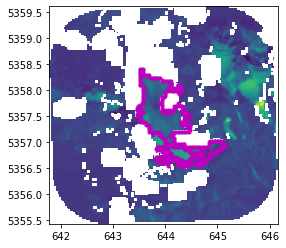

In [60]:
plt.imshow(im['SR_B2'], extent=(xmin, xmax, ymin, ymax))
for c in contours_coords[0]:
    plt.plot(c[0]/1e3, c[1]/1e3, '.m')

plt.show()